# Copyright Netherlands eScience Center <br>
**Function     : Evaluate the forecast skills for predicting the Lorenz 84 system** <br>
**Author       : Yang Liu** <br>
**First Built   : 2021.12.20** <br>
**Last Update   : 2021.12.20** <br>
**Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib**<br>
Description     : This notebook serves to evaluate the forecasts skills of vector auto-regressive model and BayesLSTM.<br>

The Lorens-84 model is described by Edward Lorens in his 1984 paper:<br>
Lorenz, E. N. (1984). Irregularity: A fundamental property of the atmosphere. Tellus A, 36(2), 98-110.<br>

Return Values   : Time series and figures <br>
**Note: Make prediction every 6 time steps**<br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import csv
import sklearn
#import scipy
import torch
import torch.nn.functional

# for autoregressive modeling
# auto regression
# from statsmodels.tsa.ar_model import AR # deprecated 
# https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AR.html#statsmodels.tsa.ar_model.AR
from statsmodels.tsa.ar_model import AutoReg
# vector autoregression
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf

sys.path.append("/mnt/e/Creator_Zone/Script_craft/ML4Climate/Scripts/DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF
import dlacs.metric

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")
###############################################################################79

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
ಠ_ಠ = "I'm a valid variable name!"
print(ಠ_ಠ)
# model type
model_type = 'lorenz84ex' # choose lorenz84 / lorenz84ex / lorenz84AA
# datapath for output
output_path = '/mnt/e/Creator_Zone/Script_craft/ML4Climate/PredictArctic/BayesMaps/Lorenz84/bayes/fullseries_ex/paperFig/ultra_long_series/per6t'
# data path of experiment
model_path = '/mnt/e/Creator_Zone/Script_craft/ML4Climate/PredictArctic/BayesMaps/Lorenz84/bayes/fullseries_ex/ultra_long_series'

I'm a valid variable name!


In [4]:
if __name__=="__main__":
    #################################################################################
    ###########                configure Lorenz 84 model                  ###########
    #################################################################################
    # Lorenz paramters and initial conditions
    x_init = 1.0 # strength of the symmetric globally encircling westerly current
    y_init = 1.0 # strength of the cosine phases of a chain of superposedwaves (large scale eddies)
    z_init = 1.0 # strength of the sine phases of a chain of superposedwaves (large scale eddies)
    F = 8.0 # temperature difference between pole and equator
    G = 1.0 # thermal forcing term
    epsilon = 0.4 # intensity of periodic forcing
    a = 0.25 # mechanical damping factor for westerly wind x
    b = 4.0 # advection strength of the waves by the westerly current
    
    # assuming the damping time for the waves is 5 days (Lorens 1984)
    dt = 0.0333 # 1/30 unit of time unit (5 days)
    num_steps = 4200
    # cut-off point of initialization period
    cut_off = 0
    # target testing period
    test_len = 1800

#### Ensemble<br>
##### Testing benchmark <br>
- Lorenz 84 model initial set-up <br>
original model<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0** <br>
with periodic forcing<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4** <br>
with AA effect<br>
**x=1.0, y=1.0, z=1.0, a=0.25, b=4.0, F=8.0, G=1.0, epsilon=0.4, alpha = 0.025, beta = 0.00625** <br>
========================================================================================================<br>
##### AR
The methods include AR and VAR, which are based on <br>
Lütkepohl, H. (2005). New introduction to multiple time series analysis. Springer Science & Business Media.<br>
========================================================================================================<br>



In [5]:
    #################################################################################
    ###########            Lorens 84 model + periodic forcing             ###########
    #################################################################################
    def lorenz84_ex(x, y, z, t, a = 0.25, b = 4.0, F = 8.0, G = 1.0, epsilon = 0.4):
        """
        Solver of Lorens-84 model with periodic external forcing.
        
        param x, y, z: location in a 3D space
        param a, b, F, G: constants and forcing
        
        The model is designed with a reference to the paper:
        Broer, H., Simó, C., & Vitolo, R. (2002). Bifurcations and strange
        attractors in the Lorenz-84 climate model with seasonal forcing. Nonlinearity, 15(4), 1205.
        
        Song, Y., Yu, Y., & Wang, H. (2011, October). The stability and chaos analysis of the
        Lorenz-84 atmosphere model with seasonal forcing. In 2011 Fourth International Workshop
        on Chaos-Fractals Theories and Applications (pp. 37-41). IEEE.
        """
        # each time step is ~ 5days, therefore the returning period are 365 / 5 = 73 times in a year
        T = 73
        omega = 2 * np.pi / T
        dx = - y**2 - z**2 - a * x + a * F * (1 + epsilon * np.cos(omega * t))
        dy = x * y - b * x * z - y + G * (1 + epsilon * np.sin(omega * t))
        dz = b * x * y + x * z - z
        
        return dx, dy, dz

In [6]:
    #################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing       ###########
    #################################################################################   
    # Need one more for the initial values
    x = np.empty(num_steps)
    y = np.empty(num_steps)
    z = np.empty(num_steps)
    t = 0.0
    
    # save initial values
    x[0] = x_init
    y[0] = y_init
    z[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps-1):
        dx, dy, dz = lorenz84_ex(x[i], y[i], z[i], t, a, b ,F, G, epsilon)
        x[i + 1] = x[i] + (dx * dt)
        y[i + 1] = y[i] + (dy * dt)
        z[i + 1] = z[i] + (dz * dt)
        t += dt

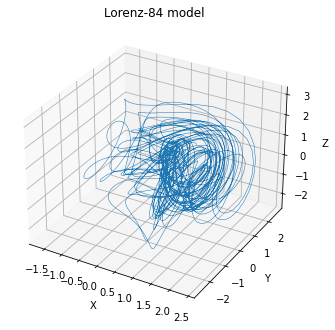

<Figure size 432x288 with 0 Axes>

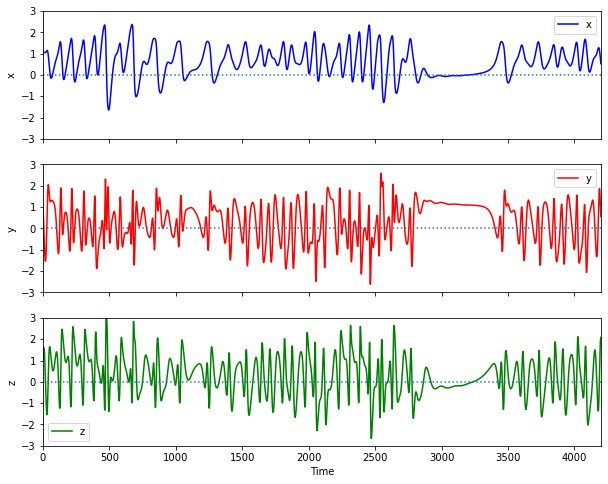

In [7]:
    #################################################################################
    ###########                 Visualize Lorens 84 model                 ###########
    #################################################################################
    # save Lorens model output
    index = np.arange(num_steps)
    # Plot
    fig00 = plt.figure(figsize=(8,5.4))
    ax = fig00.gca(projection='3d')
    ax.plot(x, y, z, lw=0.5)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Lorenz-84 model")
    plt.show()
        
    fig01 = plt.figure()
    fig01, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig01.set_size_inches(10, 8, forward=True)
    ax1.plot(index, x, 'b', label='x')
    ax2.plot(index, y, 'r', label='y')
    ax3.plot(index, z, 'g', label='z')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.axvline(x=cut_off, ls = ':')
    ax2.axvline(x=cut_off, ls = ':')
    ax3.axvline(x=cut_off, ls = ':')
    
    ax1.set_xlim(0, num_steps)
    ax2.set_xlim(0, num_steps)
    ax3.set_xlim(0, num_steps)
    
    ax1.set_ylim(-3, 3)
    ax2.set_ylim(-3, 3)
    ax3.set_ylim(-3, 3)
    
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    
    plt.xlabel("Time")
    
    ax1.legend()
    ax2.legend()
    ax3.legend()

    plt.show()

In [8]:
    print ('*******************  pre-processing  *********************')
    # time series cut-off
    if cut_off:
        x = x[cut_off:]
        y = y[cut_off:]
        z = z[cut_off:]
    print ('===================  normalize data  =====================')
    x_norm = dlacs.preprocess.operator.normalize(x)
    y_norm = dlacs.preprocess.operator.normalize(y)
    z_norm = dlacs.preprocess.operator.normalize(z)
    print('================  save the normalizing factor  =================')
    # maximum and minimum
    x_max = np.amax(x)
    x_min = np.amin(x)
    y_max = np.amax(y)
    y_min = np.amin(y)
    z_max = np.amax(z)
    z_min = np.amin(z)
    # std -> only consider the validation time
    x_std = np.std(x[-test_len:])
    y_std = np.std(y[-test_len:])
    z_std = np.std(z[-test_len:])
    
    x_std_full = np.std(x[:])
    y_std_full = np.std(y[:])
    z_std_full = np.std(z[:])

    # build the input data structure
    series_full = np.zeros((3, num_steps), dtype=float)
    series_full[0,:] = x[:]
    series_full[1,:] = y[:]
    series_full[2,:] = z[:]
    
    #series_train = series_full[:,:-test_len]
    #series_test = series_full[:,-test_len:]
    
    print("std - validation time")
    print("x", x_std)
    print("y", y_std)
    print("z", z_std)
    print("std - full series")
    print("x", x_std_full)
    print("y", y_std_full)
    print("z", z_std_full)

*******************  pre-processing  *********************
===================  normalize data  =====================
================  save the normalizing factor  =================
std - validation time
x 0.6375789869437326
y 0.8998329144374558
z 0.8236274756564372
std - full series
x 0.6676600767475926
y 0.8994888751762761
z 0.9177685982494913


In [9]:
    #######################################################################
    #######    Load forecast of Lorenz 84 model by BayesConvLSTM    #######
    #######################################################################
    print ('*******************  load ensemble data  *********************')
    # predict x steps ahead
    step_lead = 60 # unit time step
    # number of ensembles
    ens = 20
    predictand_bayes = np.zeros((ens, 3, test_len//6, step_lead), dtype=float)
    for i in range(ens):
        dataset_pred_bayes = Dataset(os.path.join(model_path, 'epoch3000_p100000_stdx16_layer3',
                                                  'base', 'epoch_2400_2800', 'per6t',
                                                  'pred_lorenz84_ens_{}_per6t.nc'.format(i)))
        predictand_bayes[i,:,:,:] = dataset_pred_bayes.variables['series'][:,:,:step_lead]     
    print(predictand_bayes.shape)
    predictand_median = np.median(predictand_bayes, 0)
    
    predictand_median_root = np.zeros((3, test_len//6, step_lead+1), dtype=float)
    predictand_median_root[0,:,0] = x_norm[-test_len-1:-1:6]
    predictand_median_root[1,:,0] = y_norm[-test_len-1:-1:6]
    predictand_median_root[2,:,0] = z_norm[-test_len-1:-1:6]
    predictand_median_root[:,:,1:] = predictand_median[:]

*******************  load ensemble data  *********************
(20, 3, 300, 60)


In [17]:
print(prob_pred_xyz.shape)

(20, 3, 300, 60)


In [12]:
    ###################################################################################################
    ###########        Launch Lorenz 84 model with periodic forcing with longer series      ###########
    ###################################################################################################
    num_steps_long = num_steps + step_lead
    # Need one more for the initial values
    xx = np.empty(num_steps_long)
    yy = np.empty(num_steps_long)
    zz = np.empty(num_steps_long)
    tt = 0.0
    
    # save initial values
    xx[0] = x_init
    yy[0] = y_init
    zz[0] = z_init
    
    # Step through "time", calculating the partial derivatives at the current point
    # and using them to estimate the next point
    for i in range(num_steps_long-1):
        dx, dy, dz = lorenz84_ex(xx[i], yy[i], zz[i], tt, a, b ,F, G, epsilon)
        xx[i + 1] = xx[i] + (dx * dt)
        yy[i + 1] = yy[i] + (dy * dt)
        zz[i + 1] = zz[i] + (dz * dt)
        tt += dt

In [13]:
    ###################################################################################
    ########                       compute the errors                          ########
    ###################################################################################
    # compute the error between forecast median and Lorenz model
    predictand_median_error = np.zeros(predictand_median.shape, dtype=float)
    for i in range(step_lead):
        predictand_median_error[0,:,i] = (predictand_median[0,:,i] * (x_max - x_min) + x_min)\
                                         - xx[-(test_len + step_lead)+i:-step_lead+i:6]
        predictand_median_error[1,:,i] = (predictand_median[1,:,i] * (y_max - y_min) + y_min)\
                                         - yy[-(test_len + step_lead)+i:-step_lead+i:6]
        predictand_median_error[2,:,i] = (predictand_median[2,:,i] * (z_max - z_min) + z_min)\
                                         - zz[-(test_len + step_lead)+i:-step_lead+i:6]
    
    #print(predictand_median_error[0,:3,:10])
    # shuffle the error
    # reshuffle a multi-dimension array with numpy.random.shuffle
    # This function only shuffles the array along the first axis of a multi-dimensional array.
    # The order of sub-arrays is changed but their contents remains the same.
    np.random.shuffle(predictand_median_error[0,:,:])
    np.random.shuffle(predictand_median_error[1,:,:])
    np.random.shuffle(predictand_median_error[2,:,:])
    #print(predictand_median_error[0,:3,:10])
    # adding root for plotting
    predictand_median_error_root = np.zeros((3, test_len//6, step_lead+1), dtype=float)
    predictand_median_error_root[:,:,0] = 0
    predictand_median_error_root[:,:,1:] = predictand_median_error[:]

In [30]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # RMSE
    def RMSE(obs, pred):
        """
        Root Mean Square Error.
        """
        rmse = np.sqrt(np.mean((obs - pred)**2))
        
        return rmse
    
    # lead time dependent RMSE of Bayesian LSTM forecast
    rmse_bayes = np.zeros((ens, step_lead+1, 3), dtype=float)
    rms_bayes_spread = np.zeros((ens, step_lead+1, 3), dtype=float)
    rmse_bayes_median_error = np.zeros((step_lead+1, 3), dtype=float)
    
    for i in range(step_lead):
        for n in range(ens):
            rmse_x_bayes = RMSE(xx[-(test_len + step_lead)+i:-step_lead+i:6], predictand_bayes[n,0,:,i]* (x_max - x_min) + x_min)    
            rmse_y_bayes = RMSE(yy[-(test_len + step_lead)+i:-step_lead+i:6], predictand_bayes[n,1,:,i]* (y_max - y_min) + y_min)
            rmse_z_bayes = RMSE(zz[-(test_len + step_lead)+i:-step_lead+i:6], predictand_bayes[n,2,:,i]* (z_max - z_min) + z_min)

            rms_x_bayes_spread = RMSE(np.mean(predictand_bayes[:,0,:,i], 0)* (x_max - x_min) + x_min, predictand_bayes[n,0,:,i]* (x_max - x_min) + x_min)
            rms_y_bayes_spread = RMSE(np.mean(predictand_bayes[:,1,:,i], 0)* (y_max - y_min) + y_min, predictand_bayes[n,1,:,i]* (y_max - y_min) + y_min)
            rms_z_bayes_spread = RMSE(np.mean(predictand_bayes[:,2,:,i], 0)* (z_max - z_min) + z_min, predictand_bayes[n,2,:,i]* (z_max - z_min) + z_min)
            
            # rms_x_bayes_spread = RMSE(np.median(predictand_bayes[:,0,:,i], 0)* (x_max - x_min) + x_min, predictand_bayes[n,0,:,i]* (x_max - x_min) + x_min)
            # rms_y_bayes_spread = RMSE(np.median(predictand_bayes[:,1,:,i], 0)* (y_max - y_min) + y_min, predictand_bayes[n,1,:,i]* (y_max - y_min) + y_min)
            # rms_z_bayes_spread = RMSE(np.median(predictand_bayes[:,2,:,i], 0)* (z_max - z_min) + z_min, predictand_bayes[n,2,:,i]* (z_max - z_min) + z_min)
            
            rmse_bayes[n,i+1,0] = rmse_x_bayes
            rmse_bayes[n,i+1,1] = rmse_y_bayes
            rmse_bayes[n,i+1,2] = rmse_z_bayes
            
            rms_bayes_spread[n,i+1,0] = rms_x_bayes_spread
            rms_bayes_spread[n,i+1,1] = rms_y_bayes_spread
            rms_bayes_spread[n,i+1,2] = rms_z_bayes_spread
            
    rmse_bayes_mean = np.mean(rmse_bayes, 0)
    rms_bayes_spread_mean = np.mean(rms_bayes_spread*3, 0)
    #rms_bayes_spread_mean = rmse_bayes_mean - rms_bayes_spread_mean

<Figure size 432x288 with 0 Axes>

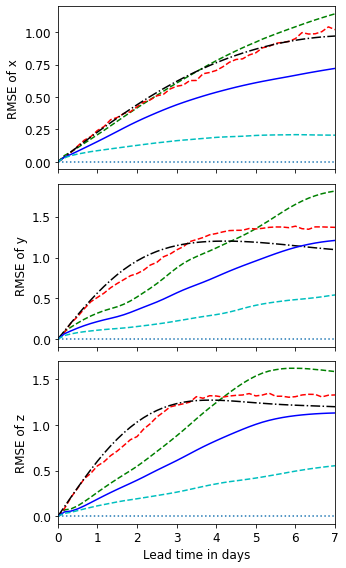

In [32]:
    ##############################################################################################################
    ###########       Compute RMSE with given ensemble predictands and deterministic observation       ###########
    ##############################################################################################################
    # Write CSV file
    # with open(os.path.join(output_path, "RMSE.csv"), "wt+") as fp:
    #     writer = csv.writer(fp, delimiter=",")
    #     writer.writerow(["x", "y", "z", "VAR"])  # write header
    #     writer.writerow(np.arange(step_lead))  # write header
    #     writer.writerows(rmse_VAR_mean.T)
    #     writer.writerow(["x", "y", "z", "Bayes"])
    #     writer.writerow(np.arange(step_lead))  # write header
    #     writer.writerows(rmse_bayes_mean.T)
    #     writer.writerow(["x", "y", "z", "persistence"])
    #     writer.writerow(np.arange(step_lead))  # write header
    #     writer.writerows(rmse_persist.T)        
        
    display_upto = 42
        
    index = np.arange(0, step_lead)
    
    fig04 = plt.figure()
    fig04, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig04.set_size_inches(4.8, 8, forward=True)
    
    # rmse of forecast
    ax1.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,0], color='g', linestyle='dashed', label='BayesLSTM random error')
    ax1.plot(np.arange(display_upto+1), rmse_VAR_mean[:display_upto+1,0], color='r', linestyle='dashed', label='VAR')
    ax1.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,0], color='k', linestyle='dashdot', label='Persistence')
    ax1.plot(np.arange(display_upto+1), rmse_bayes_mean[:display_upto+1,0], 'b', label='BayesLSTM')
    ax1.plot(np.arange(display_upto+1), rms_bayes_spread_mean[:display_upto+1,0], color='c', linestyle='dashed', label='BayesLSTM(RMS)')
    
    ax2.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,1], color='g', linestyle='dashed', label='BayesLSTM random error')
    ax2.plot(np.arange(display_upto+1), rmse_VAR_mean[:display_upto+1,1], color='r', linestyle='dashed', label='VAR')
    ax2.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,1], color='k', linestyle='dashdot', label='Persistence')
    ax2.plot(np.arange(display_upto+1), rmse_bayes_mean[:display_upto+1,1], 'b', label='BayesLSTM')
    ax2.plot(np.arange(display_upto+1), rms_bayes_spread_mean[:display_upto+1,1], color='c', linestyle='dashed', label='BayesLSTM(RMS)')
    
    ax3.plot(np.arange(display_upto+1), rmse_bayes_median_error[:display_upto+1,2], color='g', linestyle='dashed', label='BayesLSTM random error')
    ax3.plot(np.arange(display_upto+1), rmse_VAR_mean[:display_upto+1,2], color='r', linestyle='dashed', label='VAR')
    ax3.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,2], color='k', linestyle='dashdot', label='Persistence')
    ax3.plot(np.arange(display_upto+1), rmse_bayes_mean[:display_upto+1,2], 'b', label='BayesLSTM')
    ax3.plot(np.arange(display_upto+1), rms_bayes_spread_mean[:display_upto+1,2], color='c', linestyle='dashed', label='BayesLSTM(RMS)')
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    ax1.set_xticks(np.arange(0,display_upto+1,3))
    ax2.set_xticks(np.arange(0,display_upto+1,3))
    ax3.set_xticks(np.arange(0,display_upto+1,3))
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x", fontsize=12)
    ax2.set_ylabel("RMSE of y", fontsize=12)
    ax3.set_ylabel("RMSE of z", fontsize=12)
    
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1))
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax3.tick_params(axis='both', which='major', labelsize=12)
    
    # ax1.legend(frameon=True, bbox_to_anchor=(0.005,0.995), prop={'size': 11.0}, loc=2)
    # ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 11.0}, loc=4)
    # ax3.legend(frameon=True, bbox_to_anchor=(1.05,0.5), prop={'size': 11.0}, loc='center left',) # only 4 legend
    
    plt.tight_layout()

    plt.show()
    fig04.savefig(os.path.join(output_path,'rmse.png'),dpi=150)
    # fig04.savefig(os.path.join(output_path,'rmse4legend.png'),dpi=150) # only 4 legend

<Figure size 432x288 with 0 Axes>

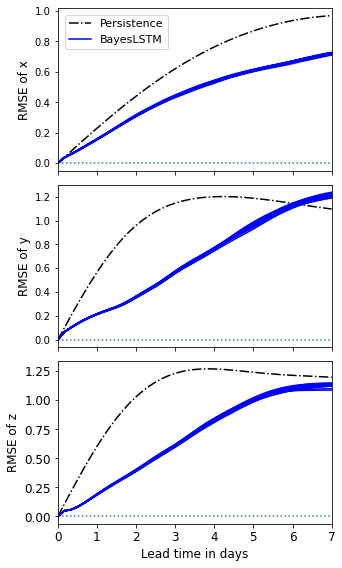

In [20]:
    ##########################################################################
    ###########       Display RMSE initial v.s. error growth       ###########
    ##########################################################################
    display_upto = 42
    
    fig041 = plt.figure()
    fig041, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex=True)
    fig041.set_size_inches(4.8, 8, forward=True)    
    
    ax1.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,0], color='k', linestyle='dashdot', label='Persistence')
    for n in range(ens):
        if n==0:
            ax1.plot(np.arange(display_upto+1), rmse_bayes[n,:display_upto+1,0], 'b', label='BayesLSTM')
        else:
            ax1.plot(np.arange(display_upto+1), rmse_bayes[n,:display_upto+1,0], 'b')
    
    ax2.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,1], color='k', linestyle='dashdot', label='Persistence')
    for n in range(ens):
        ax2.plot(np.arange(display_upto+1), rmse_bayes[n,:display_upto+1,1], 'b', label='BayesLSTM')
    
    ax3.plot(np.arange(display_upto+1), rmse_persist[:display_upto+1,2], color='k', linestyle='dashdot', label='Persistence')
    for n in range(ens):
        ax3.plot(np.arange(display_upto+1), rmse_bayes[n,:display_upto+1,2], 'b', label='BayesLSTM')  
    
    ax1.axhline(y=0, ls = ':')
    ax2.axhline(y=0, ls = ':')
    ax3.axhline(y=0, ls = ':')
    
    ax1.set_xlim(0, display_upto)
    ax2.set_xlim(0, display_upto)
    ax3.set_xlim(0, display_upto)
    
    #ax1.set_ylim(0, 0.5)
    #ax2.set_ylim(0, 0.5)
    #ax3.set_ylim(0, 0.5)
    
    ax1.set_ylabel("RMSE of x", fontsize=12)
    ax2.set_ylabel("RMSE of y", fontsize=12)
    ax3.set_ylabel("RMSE of z", fontsize=12)
    
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1))
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    ax1.legend(frameon=True, bbox_to_anchor=(0.005,0.995), prop={'size': 11.0}, loc=2)
    #ax2.legend(frameon=True, bbox_to_anchor=(0.98,0.05), prop={'size': 7.5}, loc=4)
    #ax3.legend(frameon=True, bbox_to_anchor=(0.995,0.03), prop={'size': 10.0}, loc=4)
    
    plt.tight_layout()

    plt.show()
    #fig041.savefig(os.path.join(output_path,'rmse_spread_error_growth.png'),dpi=150)    

In [22]:
    ##############################################################################################################
    ###########       Compute Euclidean distance with given ensemble predictands and observation       ###########
    ##############################################################################################################
    # Euclidean distance
    def Euclidean(obs, pred):
        """
        Measure the Euclidean distance.
        ----------------------
        param obs: observation time series with the shape [dim, series]
        param pred: reference time series with the shape [dim, series]        
        """
        euclidean = np.mean(np.sqrt(np.sum((obs-pred)**2,0)))
        
        return euclidean
    
    # lead time dependent Euclidean distance of Bayesian forecast
    euclidean_bayes_ens = np.zeros((ens, step_lead+1), dtype=float)
    euclidean_bayes_median_error_denorm = np.zeros((step_lead+1), dtype=float)
    euclidean_VAR_prob_ens = np.zeros((ens,step_lead+1), dtype=float)
    euclidean_persist = np.zeros(step_lead+1, dtype=float)
    
    obs = np.zeros((3, num_steps_long), dtype=float)
    obs[0,:] = xx[:]
    obs[1,:] = yy[:]
    obs[2,:] = zz[:]
    
    predictand_bayes_denorm = np.zeros(predictand_bayes.shape, dtype=float)
    predictand_bayes_denorm[:,0,:,:] = predictand_bayes[:,0,:,:] * (x_max - x_min) + x_min
    predictand_bayes_denorm[:,1,:,:] = predictand_bayes[:,1,:,:] * (y_max - y_min) + y_min
    predictand_bayes_denorm[:,2,:,:] = predictand_bayes[:,2,:,:] * (z_max - z_min) + z_min
    
    predictand_bayes_median_error_denorm = np.zeros(predictand_median[:,:,:].shape, dtype=float)
    predictand_bayes_median_error_denorm[0,:,:] = predictand_median[0,:,:] * (x_max - x_min) + x_min + predictand_median_error[0,:,:]
    predictand_bayes_median_error_denorm[1,:,:] = predictand_median[1,:,:] * (y_max - y_min) + y_min + predictand_median_error[1,:,:]
    predictand_bayes_median_error_denorm[2,:,:] = predictand_median[2,:,:] * (z_max - z_min) + z_min + predictand_median_error[2,:,:]
    
    for i in range(step_lead):
        euclidean_persist[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i:6], obs[:,-(test_len + step_lead)-1:-step_lead-1:6])
        euclidean_bayes_median_error_denorm[i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i:6], predictand_bayes_median_error_denorm[:,:,i])        
        for n in range(ens):
            euclidean_VAR_prob_ens[n,i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i:6], prob_pred_xyz[n,:,:,i])
            euclidean_bayes_ens[n,i+1] = Euclidean(obs[:,-(test_len + step_lead)+i:-step_lead+i:6], predictand_bayes_denorm[n,:,:,i])

    euclidean_bayes = np.mean(euclidean_bayes_ens, 0)
    euclidean_VAR_prob = np.mean(euclidean_VAR_prob_ens, 0)

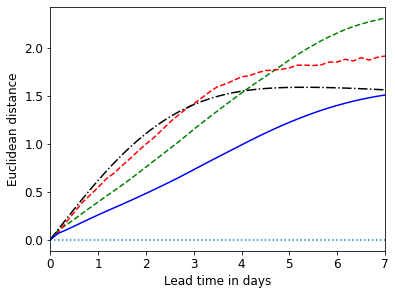

In [23]:
    #colormap=cm.tab20c(range(20))
    colormap=cm.tab10(range(10))
    # zoom in
    display_upto = 42
    
    std_trajectory_ref = np.ones(display_upto+1,dtype=float)
    trajectory_std = np.std(np.sqrt(x**2 + y**2 + z**2))
    std_trajectory_ref = std_trajectory_ref * trajectory_std
    
    fig05 = plt.figure()
    fig05.set_size_inches(5.6, 4.2, forward=True)
    
    plt.plot(np.arange(display_upto+1), euclidean_bayes_median_error_denorm[:display_upto+1], color='g', linestyle='dashed', label='BayesLSTM random error')
    plt.plot(np.arange(display_upto+1), euclidean_VAR_prob[:display_upto+1], color='r', linestyle='dashed', label='VAR')
    plt.plot(np.arange(display_upto+1), euclidean_persist[:display_upto+1], color='k', linestyle='dashdot', label='Persistence')
    plt.plot(np.arange(display_upto+1), euclidean_bayes[:display_upto+1], color='b', label='BayesLSTM')
    plt.axhline(y=0, ls = ':')
    plt.xlim(0, display_upto)
    plt.xticks(np.arange(0,display_upto+1,3),fontsize=12)
    
    plt.ylabel("Euclidean distance", fontsize=12)
    plt.xlabel("Lead time in days", fontsize=12)
    
    plt.xticks(np.arange(0,display_upto+1,6),np.arange(0,display_upto//6+1))
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    #plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.005,0.99), loc=2, ncol=1)
    # plt.legend(frameon=True, prop={'size': 11.0}, bbox_to_anchor=(0.99,0.05), loc=4, ncol=1)
    plt.tight_layout()

    plt.show()
    fig05.savefig(os.path.join(output_path,'euclidean.png'),dpi=150)